In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow keras scikeras

In [ ]:
from datetime import datetime, timedelta

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Manipulação de Dados
import numpy as np
import pandas as pd

In [ ]:
# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Importação da biblioteca de finanças para coleta de dados
import yfinance as yf

In [ ]:
# Importações pertinentes ao scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Bibliotecas para cálculo de métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
# Importações pertinentes ao TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# SciKeras (para integração com scikit-learn)
from scikeras.wrappers import KerasRegressor

In [ ]:

from typing import Tuple


def create_dataset(data: np.ndarray, prediction_days: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    """
    Transforma dados de séries temporais em um formato adequado para aprendizado supervisionado,
    preparando sequências de entrada e valores alvo para treinamento de modelos como LSTM.

    Parâmetros:
    - data (np.ndarray): Array NumPy contendo os dados de séries temporais, com shape (n_samples, n_features).
                         Os dados devem ser pré-processados (por exemplo, normalizados) antes de serem passados para a função.
    - prediction_days (int, opcional): Número de passos de tempo (dias) a serem usados para prever o próximo valor.
                                       O valor padrão é 60.

    Retorna:
    - x (np.ndarray): Array de sequências de entrada, com shape (n_samples - prediction_days, prediction_days).
    - y (np.ndarray): Array de valores alvo correspondentes, com shape (n_samples - prediction_days,).

    Exemplo:
    Se prediction_days = 60, cada x[i] conterá 60 valores anteriores, e y[i] conterá o valor imediatamente seguinte.
    """
    # Inicializa listas vazias para armazenar as sequências de entrada (x) e os valores alvo (y)
    x, y = [], []

    # Itera sobre o índice a partir de 'prediction_days' até o final dos dados
    for i in range(prediction_days, len(data)):
        # Extrai a sequência de entrada de 'prediction_days' valores anteriores
        x_sequence = data[i - prediction_days:i, 0]
        x.append(x_sequence)

        # Extrai o valor alvo correspondente (o valor imediatamente após a sequência)
        y_value = data[i, 0]
        y.append(y_value)

    # Converte as listas x e y em arrays NumPy e retorna
    return np.array(x), np.array(y)

In [ ]:
symbol = 'AAPL'
start_date = (datetime.now() - timedelta(days=1095)).strftime('%Y-%m-%d')
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

# Baixe os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Visualizando o shape dos nossos dados
df.shape

(753, 6)

In [ ]:
# Obtendo mais informação sobre as colunas, se há valores nulos e a tipagem de cada dado
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2021-11-29 00:00:00+00:00 to 2024-11-25 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  753 non-null    float64
 1   (Close, AAPL)      753 non-null    float64
 2   (High, AAPL)       753 non-null    float64
 3   (Low, AAPL)        753 non-null    float64
 4   (Open, AAPL)       753 non-null    float64
 5   (Volume, AAPL)     753 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.2 KB


In [ ]:
# Exibindo mais uma vez o nome das colunas
df.columns

MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [ ]:
# Selecionando a coluna 'close' como DataFrame
data = df[['Close']]

# Convertendo para array numpy
dataset = data.values

# Verificando o número de amostras
print("Total de amostras:", len(dataset))

Total de amostras: 753


In [ ]:
# Aplicando o StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [ ]:
prediction_days = 60
x, y = create_dataset(scaled_data, prediction_days)

In [ ]:
# Dividindo os dados em treino e teste usando slicing
training_data_len = int(np.ceil(len(y) * 0.8))

In [ ]:
# Separando os dados de TREINO usando o slicing do NumPy para garantir que preservamos a série temporal
X_train = x[:training_data_len]
y_train = y[:training_data_len]

# Separando os dados de TESTE usando o slicing do NumPy para garantir que preservamos a série temporal
X_test = x[training_data_len:]
y_test = y[training_data_len:]

In [ ]:
# Redimensionando os dados para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

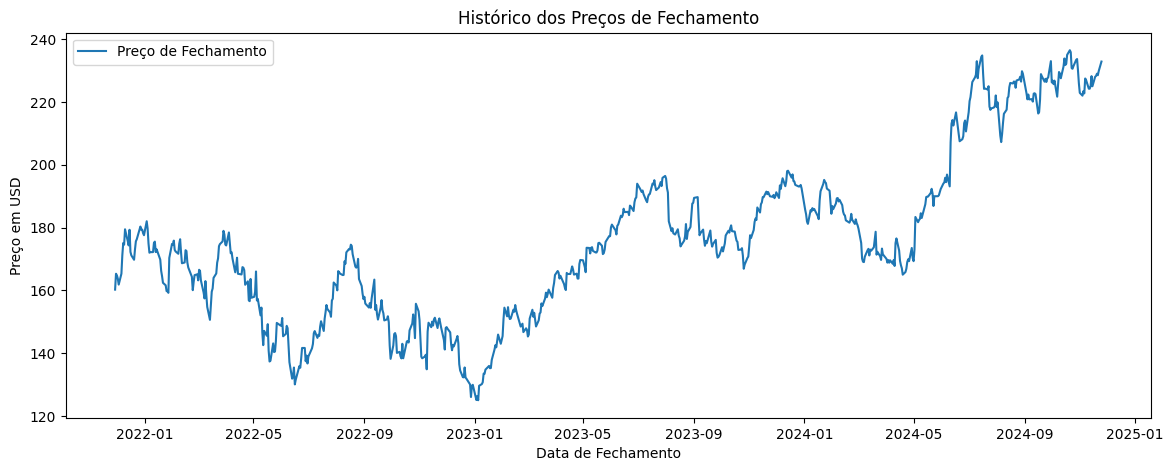

In [ ]:
# Após separar os dados de TRAIN/TEST é pertinente plotarmos um gráfico para fazer uma análise visual do preço de fechamento da ação
plt.figure(figsize=(14,5))
plt.plot(data.index, data['Close'], label='Preço de Fechamento')
plt.title('Histórico dos Preços de Fechamento')
plt.xlabel('Data de Fechamento')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

In [ ]:
from typing import Tuple


def create_model(
    input_shape: Tuple[int, int],
    units: int = 50,
    dropout_rate: float = 0.2,
    optimizer: str = 'adam',
    activation: str = 'tanh'
) -> Sequential:
    """
    Cria e compila um modelo de rede neural recorrente LSTM para previsão de séries temporais.

    Parâmetros:
    - input_shape (tuple): Shape dos dados de entrada na forma (timesteps, features).
    - units (int, opcional): Número de unidades em cada camada LSTM.
    - dropout_rate (float, opcional): Taxa de dropout para regularização.
    - optimizer (str, opcional): Otimizador para a compilação do modelo.
    - activation (str, opcional): Função de ativação para as camadas LSTM.

    Retorna:
    - model (Sequential): Modelo LSTM compilado.
    """
    model = Sequential()

    # Adiciona a camada de entrada
    model.add(Input(shape=input_shape))

    # Primeira camada LSTM com retorno de sequências
    model.add(
        LSTM(
            units=units,
            return_sequences=True,
            activation=activation
        )
    )
    model.add(Dropout(dropout_rate))

    # Segunda camada LSTM sem retorno de sequências
    model.add(
        LSTM(
            units=units,
            activation=activation
        )
    )
    model.add(Dropout(dropout_rate))

    # Camada de saída
    model.add(Dense(1))

    # Compilação do modelo
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [ ]:
# Definindo o uso de Early Stopping para o modelo, com o intuito de ganharmos tempo e obtermos o melhor resultado possível
early_stopping = EarlyStopping(
    monitor='val_loss',          # Métrica a ser monitorada
    patience=3,                  # Número de épocas sem melhoria antes de parar
    restore_best_weights=True    # Restaurar os pesos da melhor época
)

In [ ]:
# Define o shape de entrada baseado nos seus dados
input_shape = (X_train.shape[1], 1)

# Cria o regressor Keras com o modelo definido na função 'create_model'
model = KerasRegressor(
    model=create_model,
    input_shape=input_shape,
    units=50,
    dropout_rate=0.2,
    optimizer='adam',
    activation='tanh',
    epochs=30,
    batch_size=32,
    verbose=1,
    fit__validation_split=0.1,      # Divisão do conjunto de validação
    fit__callbacks=[early_stopping], # Passando o EarlyStopping aqui
    fit__shuffle=False               # Desabilitando o embaralhamento
)

In [ ]:
# Define o validador cruzado para séries temporais
tscv = TimeSeriesSplit(n_splits=3)

# Definição dos parâmetros que vão ser testados na validação cruzada
param_grid = {
    'units': [400],
    'dropout_rate': [0.05, 0.08, 0.1],
    'optimizer': ['adam'],
    'activation': ['tanh'],
    'batch_size': [8]
}

In [ ]:
# Configura o GridSearchCV com o validador
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

In [ ]:
# Executa o ajuste do modelo
grid_result = grid.fit(
    X_train,
    y_train
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step - loss: 0.2745 - val_loss: 0.0253
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step - loss: 0.0921 - val_loss: 0.0283
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - loss: 0.0590 - val_loss: 0.0246
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 518ms/step - loss: 0.0428 - val_loss: 0.0214
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 575ms/step - loss: 0.0368 - val_loss: 0.0205
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 530ms/step - loss: 0.0336 - val_loss: 0.0196
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 523ms/step - loss: 0.0322 - val_loss: 0.0194
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 543ms/step - loss: 0.0309 - val_loss: 0.0178
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 523ms/step - loss: 0.0288 - val_loss: 0.0177
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - loss: 0.0291 - val_loss: 0.0174
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 518ms/step - loss: 0.0266 - val_loss: 0.0160
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 40

In [ ]:
# Obtendo o melhor modelo definido pela validação cruzada
best_model = grid_result.best_estimator_

# Acessar o histórico de treinamento do melhor modelo
history = best_model.history_

# Número de épocas treinadas
num_epochs_trained = len(history['loss'])

In [ ]:
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
print(f"O melhor modelo treinou por {num_epochs_trained} épocas.")

Melhor: -0.102593 usando {'activation': 'tanh', 'batch_size': 8, 'dropout_rate': 0.05, 'optimizer': 'adam', 'units': 400}
O melhor modelo treinou por 19 épocas.


In [ ]:
# Realiza previsões no conjunto de teste
predictions: np.ndarray = best_model.predict(X_test)

# Redimensiona o array de previsões para garantir que tem duas dimensões
predictions = predictions.reshape(-1, 1)

# Aplica a transformação inversa para retornar as previsões à escala original
predictions = scaler.inverse_transform(predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


In [ ]:
# Redimensiona o array de valores reais de teste para garantir que tem duas dimensões
y_test_scaled: np.ndarray = y_test.reshape(-1, 1)

# Aplica a transformação inversa para retornar os valores reais à escala original (Usamos o StandardScaler, lembra?)
y_test_scaled = scaler.inverse_transform(y_test_scaled)

In [ ]:
# Calculando as métricas de erro
mae = mean_absolute_error(y_test_scaled, predictions)
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_scaled, predictions)

# Exibindo os resultados
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 2.8780781842660215
MSE: 13.449811621425686
RMSE: 3.6673984814069067
MAPE: 0.013153950426227152


* MAE: 8.141435276378285
* MSE: 84.45970622163573
* RMSE: 9.190196201476644
* MAPE: 0.0358615272636087

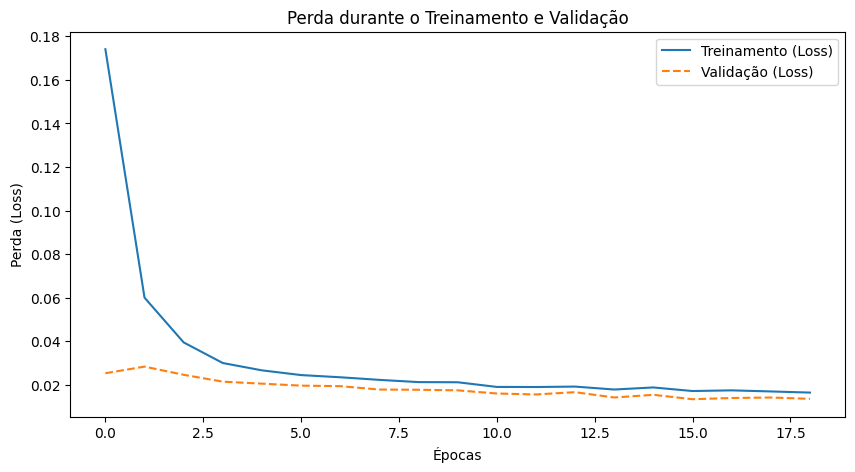

In [ ]:
# Acessar o histórico do modelo
loss = history['loss']
val_loss = history['val_loss']

# Plotar as perdas de treino e validação
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Treinamento (Loss)')
plt.plot(val_loss, label='Validação (Loss)', linestyle='--')
plt.title('Perda durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.show()

In [ ]:
mean_cv_score = grid_result.cv_results_['mean_test_score']
std_cv_score = grid_result.cv_results_['std_test_score']

print(f"Média dos Scores da Validação Cruzada: {mean_cv_score}")
print(f"Desvio Padrão dos Scores da Validação Cruzada: {std_cv_score}")


Média dos Scores da Validação Cruzada: [-0.10259322 -0.11779495 -0.12155991]
Desvio Padrão dos Scores da Validação Cruzada: [0.02473068 0.04452075 0.01526682]


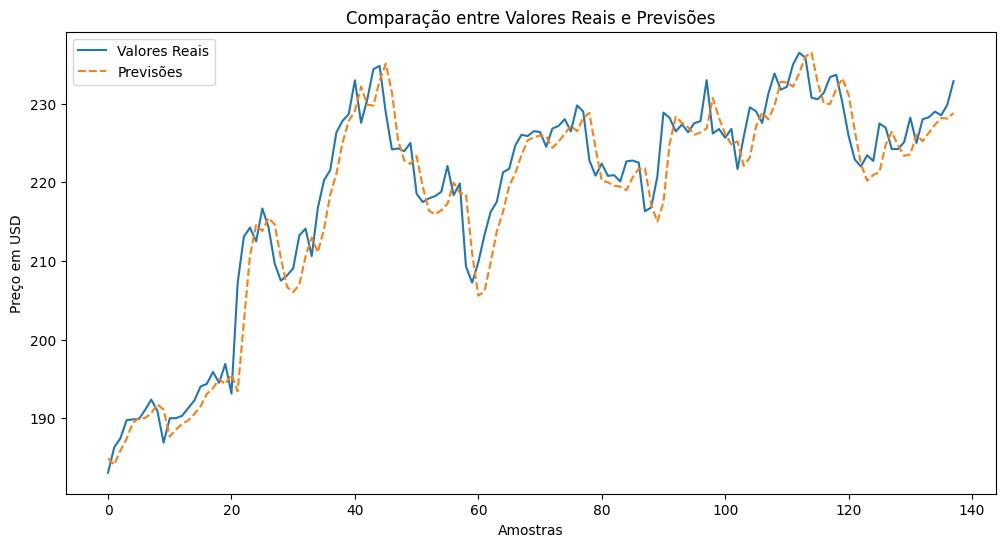

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Valores Reais')
plt.plot(predictions, label='Previsões', linestyle='--')
plt.title('Comparação entre Valores Reais e Previsões')
plt.xlabel('Amostras')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

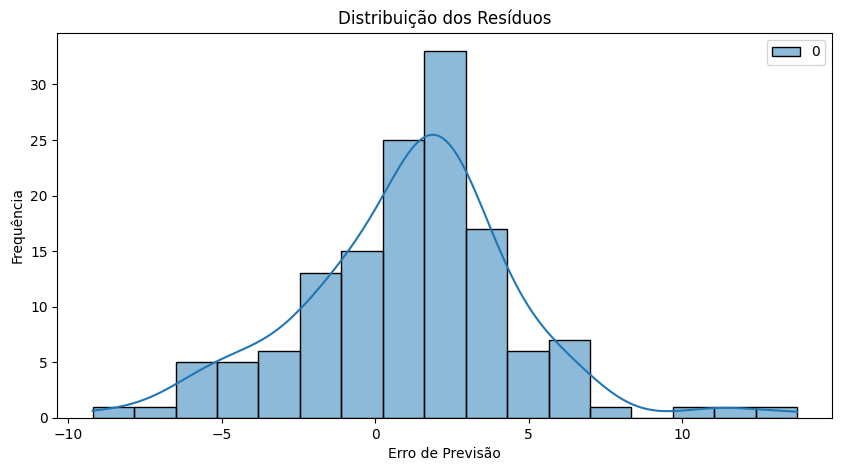

In [ ]:
residuals = y_test_scaled - predictions

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.xlabel('Erro de Previsão')
plt.ylabel('Frequência')
plt.show()

In [ ]:
# Passo 2: Definir o caminho e salvar o modelo
save_path = '/content/drive/My Drive/best_lstm_model_v4.keras'
best_model.model_.save(save_path)

# Passo 3: (Opcional) Confirmar a existência do arquivo via código
import os
if os.path.exists(save_path):
    print("O modelo foi salvo com sucesso no Google Drive.")
else:
    print("Falha ao salvar o modelo no Google Drive.")

O modelo foi salvo com sucesso no Google Drive.
